# Import Dependencies

In [974]:
import torch
# from torch import Tensor
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.optimize import minimize
# from pymoo.problems import get_problem
from pymoo.core.problem import Problem

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

from pymoo.core.problem import Problem
from pymoo.core.result import Result

from pymoo.optimize import minimize

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.patches as patches
import seaborn as sns
style.use("ggplot")


# Make Data & Environmet & Practical Function

In [975]:
def generate_structured_environment(size_cm, num_blocks=5, block_size_range=(5, 20), seed=None):
    """
    size_cm: tuple[int] مثل (100, 100)
    dimension: 2 یا 3
    num_blocks: تعداد ساختارهای مانعی (مثل دیوار یا ستون)
    block_size_range: حداقل و حداکثر اندازه‌ی هر مانع (به سانتی‌متر)
    seed: مقدار تصادفی ثابت برای reproducibility
    
    خروجی: تنسور محیط با 0 و 1
    """
    import torch
    import numpy as np
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    dimension = len(size_cm)
    if dimension == 2:
        H, W = size_cm
        env = torch.zeros((H, W), dtype=torch.float32)
    elif dimension == 3:
        H, W, D = size_cm
        env = torch.zeros((H, W, D), dtype=torch.float32)
    else:
        raise ValueError("Only 2D or 3D is supported.")

    for _ in range(num_blocks):
        if dimension == 2:
            h = np.random.randint(block_size_range[0], block_size_range[1])
            w = np.random.randint(block_size_range[0], block_size_range[1])
            x = np.random.randint(0, H - h)
            y = np.random.randint(0, W - w)
            env[x:x+h, y:y+w] = 1.0  # مانع مستطیلی
        else:
            h = np.random.randint(block_size_range[0], block_size_range[1])
            w = np.random.randint(block_size_range[0], block_size_range[1])
            d = np.random.randint(block_size_range[0], block_size_range[1])
            x = np.random.randint(0, H - h)
            y = np.random.randint(0, W - w)
            z = np.random.randint(0, D - d)
            env[x:x+h, y:y+w, z:z+d] = 1.0  # مانع مکعبی

    return env


def nodes_pose(num_pop : int, num_node : int = 5, dimension : int = 2):
    X = torch.rand(num_pop, num_node, dimension, requires_grad=True)
    return X

def denormalize_positions(X_norm: torch.Tensor, size_cm : tuple[int,int] ) -> torch.Tensor:
    """
    X_norm: تنسور با مقادیر نرمالیزه شده بین 0 و 1  
    size_cm: اندازه‌ی محیط به سانتی‌متر (مثلا (100, 100) یا (100, 100, 100))
    """
    if len(size_cm) == 2:
        size_tensor = torch.tensor(size_cm, dtype=X_norm.dtype, device=X_norm.device)
    elif len(size_cm) == 3:
        # برای 3 بعدی، اندازه باید به صورت (H, W, D) باشد
        if len(size_cm) != 3:
            raise ValueError("For 3D input, size_cm must be a tuple of length 3.")
        # تبدیل به تنسور با نوع و دستگاه مشابه X_norm
    size_tensor = torch.tensor(size_cm, dtype= X_norm.dtype , device=X_norm.device)
    return (X_norm * size_tensor).float()  # این هنوز leaf نیست ولی گراف وصله


def positioning_nodes(env : torch.Tensor , nodes_pose : torch.Tensor , defines_as : int = 2):
    env_prime = env.clone()
    nodes_pose = nodes_pose.long()
    for pos in nodes_pose:
        if defines_as == 3 and env_prime[pos[0], pos[1]] == 1:
            print(f"Position {pos} is already occupied in the environment.", )
        else:
            env_prime[pos[0], pos[1]] = defines_as
    return env_prime


def find_best(X : torch.Tensor, 
              fn : nn.Module,
              verbose : bool = True) -> torch.Tensor:
    best_answer = torch.argmax(
    torch.tensor([fn(X[i])
      for i in range(X.shape[0])]))
    if verbose:
        print(f"Best Answer is in index: {best_answer}")
    
    return X[best_answer]



# Visulizer Functions

In [976]:
def plot_2d_environment(env_tensor: torch.Tensor, radii: torch.Tensor | None = None):
    """
    env_tensor: ماتریس 2D که مقادیر:
        0: فضای آزاد
        1: مانع
        2: سنسور
        3: علامت ستاره

    radii: تنسور 1D به طول تعداد سنسورها (2ها)، شامل شعاع‌های دایره‌ی توخالی دور هر سنسور
    """

    H, W = env_tensor.shape
    plt.figure(figsize=(6, 6))
    plt.imshow((env_tensor == 1).numpy(), cmap='Greys', origin='upper')  # فقط موانع

    ax = plt.gca()
    sensor_indices = []

    for y in range(H):
        for x in range(W):
            val = env_tensor[y, x].item()
            if val == 2:
                plt.plot(x, y, 'ro', markersize=8, label='Sensor' if not sensor_indices else "")
                sensor_indices.append((x, y))
            elif val == 3:
                plt.plot(x, y, 'b*', markersize=12, label='Star')

    # اضافه‌کردن دایره‌های توخالی بر اساس شعاع‌ها
    if radii is not None:
        assert len(radii) == len(sensor_indices), "طول radii باید با تعداد سنسورها (2ها) برابر باشد."
        for (x, y), radius in zip(sensor_indices, radii):
            circle = patches.Circle((x, y), radius.item(), fill=False, edgecolor='r', linestyle='--', linewidth=1.5)
            ax.add_patch(circle)

    # تنظیمات نهایی
    plt.title("2D Environment")
    plt.xlabel("X axis (cm)")
    plt.ylabel("Y axis (cm)")
    plt.xlim(-0.5, W - 0.5)
    plt.ylim(H - 0.5, -0.5)
    plt.grid(False)

    handles, labels = plt.gca().get_legend_handles_labels()
    # if handles:
    #     plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_3d_environment_slices(env_tensor, axis=2):
    """
    env_tensor: تنسور 3بعدی PyTorch
    axis: محور ثابت نگه‌داشته شده برای slice (مثل Z ثابت = تصاویر XY)
    """
    import matplotlib.pyplot as plt

    slices = env_tensor.shape[axis]
    fig, axs = plt.subplots(1, min(slices, 5), figsize=(15, 3))

    for i in range(min(slices, 5)):
        if axis == 0:
            img = env_tensor[i, :, :]
        elif axis == 1:
            img = env_tensor[:, i, :]
        else:
            img = env_tensor[:, :, i]
        axs[i].imshow(img.numpy(), cmap='Greys', origin='lower')
        axs[i].set_title(f"Slice {i}")
        axs[i].axis('off')

    plt.suptitle("Slices of 3D Environment")
    plt.show()

# define Everything

In [977]:
ENV_SIZE : tuple[int,int] = (100, 100)
NUM_BLOCKS : int = 2
BLOCK_SIZE : tuple[int, int ] = (10,20)

pop_size = 100
Dimension = 2 
Learning_rate = .23

X : int = 10
K : int = 5

n_simu = 30
chance_in_net_favor = .30
n_epoch = 1

Radius = 11
obstacle_weight= 10
intra_distance_weight = .1
target_distance_weight = 11

radii = torch.ones(size= (X,)) * 10 #torch.randint(low=5, high=10, size=(X,))
SEED = None


first_env = generate_structured_environment(size_cm = ENV_SIZE,
                                            num_blocks = NUM_BLOCKS ,
                                            block_size_range= BLOCK_SIZE,
                                            seed=SEED)

Sensor_Nodes = nodes_pose(num_pop= pop_size, num_node = X)
Target_Points = nodes_pose(num_pop= pop_size, num_node = K)

new_X = denormalize_positions(Sensor_Nodes[0], ENV_SIZE)
new_target_point = denormalize_positions(Target_Points[0], ENV_SIZE)
# new_X.retain_grad()

first_env = positioning_nodes(first_env, new_target_point, 3)
# Visualize initial environment
new_env = positioning_nodes(first_env, new_X)


# Display one of many

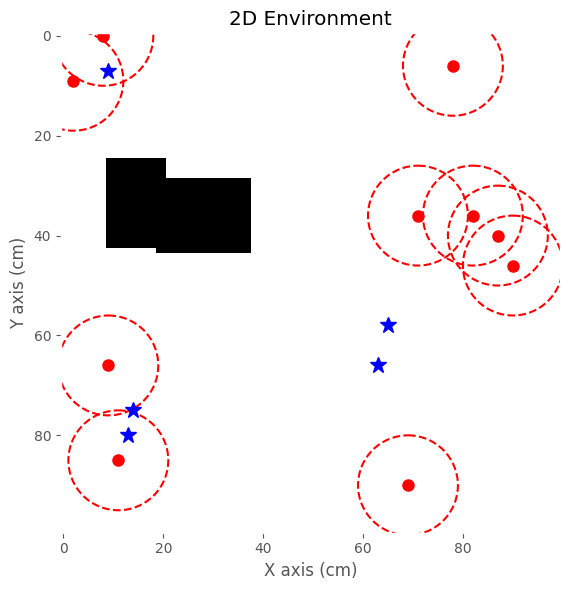

In [978]:
plot_2d_environment(new_env, radii=radii)


# Define Fitness(Loss) Function

$ fitness(X) = \sum  || x_i - x_j ||_2 + \sum || x_i - t_i ||_2 - \lambda      \text{||X||}$

In [979]:
def masked_centered_convolution_sum(x: torch.Tensor, kernel_size: int = 3) -> torch.Tensor:
    """
    Compute convolution sum centered on sensor positions, ignoring obstacles.
    
    Args:
        x (torch.Tensor): 2D environment tensor (2: sensor, 1: obstacle, 0: free).
        kernel_size (int): Size of the convolution kernel.
    
    Returns:
        torch.Tensor: Sum of convolution values at sensor positions.
    """
    # assert x.dim() == 2
    P , H, W = x.shape
    pad = kernel_size // 2

    kernel = torch.ones((kernel_size, kernel_size), dtype=x.dtype, device=x.device, requires_grad=True)
    total = torch.tensor(0.0, dtype=x.dtype, device=x.device, requires_grad=True)

    for p in range(P):
        # Iterate over each sensor position in the batch
        for i in range(pad, H - pad):
            for j in range(pad, W - pad):
                if x[p, i, j].item() == 2:
                    patch = x[p, i-pad:i+pad+1, j-pad:j+pad+1]
                    obstacle_mask = (patch != 1).float()
                    masked_patch = patch * obstacle_mask
                    total = total + (masked_patch * kernel).sum()
    # for i in range(pad, H - pad):
    #     for j in range(pad, W - pad):
    #         if x[i, j].item() == 2:
    #             patch = x[i-pad:i+pad+1, j-pad:j+pad+1]
    #             obstacle_mask = (patch != 1).float()
    #             masked_patch = patch * obstacle_mask
    #             total = total + (masked_patch * kernel).sum()

    return total

class FitnessLoss(nn.Module):
    def __init__(self,
                 first_env : torch.Tensor, 
                 radius=3, 
                 target_point=None, 
                 obstacle_weight=1.0, 
                 intra_distance_weight=1.0, 
                 target_distance_weight=1.0):
        """
        radius: شعاع کانولوشن
        target_point: نقطه هدف (1, d)
        obstacle_weight: ضریب جریمه نزدیک شدن به موانع
        intra_distance_weight: ضریب فاصله بین سنسورها
        target_distance_weight: ضریب فاصله از هدف
        """
        super().__init__()
        self.radius = radius
        self.target_point = target_point.detach().clone() if target_point is not None else None
        self.obstacle_weight = obstacle_weight
        self.intra_distance_weight = intra_distance_weight
        self.target_distance_weight = target_distance_weight
        self.first_env = first_env

    def forward(self, 
                X: torch.Tensor, 
                ) -> torch.Tensor:
        """
        Compute fitness loss for sensor positions.
        
        Args:
            X (torch.Tensor): Sensor positions, shape (num_sensors, dimension).
            env (torch.Tensor): 2D environment tensor.
        
        Returns:
            torch.Tensor: Total loss (to be minimized).
        """
        # فاصله بین سنسورها
        dists_intra = torch.cdist(X, X, p=2)
        # intra_sum = F.normalize(dists_intra).sum()
        intra_sum = dists_intra.sum() #/ (X.shape[0] * (X.shape[0] - 1) + 1e-6)  # Normalize

        # فاصله تا هدف
        if self.target_point is not None:
            dists_target = torch.cdist(X, self.target_point, p=2)
            # target_sum = F.normalize(dists_target).sum()
            target_sum = dists_target.sum() #/ (X.shape[0] * self.target_point.shape[0] + 1e-6)  # Normalize

        # کانولوشن موانع
        kernel_size = 2 * self.radius + 1
        kernel = torch.ones((1, 1, kernel_size, kernel_size), # [out_ch, in_ch, kH, kW]
                             dtype=X.dtype, device=X.device, 
                             requires_grad=False)

        # [batch, channels, height, width] 
        # for input and [out_channels, in_channels, kH, kW] for kernel.
        # کانولوشن برای محاسبه جریمه موانع
        conv = nn.Conv2d(in_channels=1, 
                        out_channels=1,
                        bias=False,
                        kernel_size=self.radius,
                        padding='same', 
                        groups=1)
        conv.weight = nn.Parameter(kernel)  
        env_input = self.first_env.unsqueeze(0).unsqueeze(0)  # shape = [1, 1, 100, 100]
        obstacle_penalty = F.normalize(conv(env_input)).sum()  
        # obstacle_penalty = masked_centered_convolution_sum(env_input.squeeze(0), kernel_size)

        loss = (
            self.intra_distance_weight * intra_sum +
            self.target_distance_weight * target_sum -
            self.obstacle_weight * obstacle_penalty
        )

        return -loss


# Traditional Evolutionary Method

In [980]:


class DCPMK(Problem):
    def __init__(self, 
                 pos: torch.Tensor, 
                 env: torch.Tensor,
                 target_point: torch.Tensor, 
                 fitness_loss: nn.Module,
                #  radius: int = 3, 
                #  obstacle_weight: float = 1.0, 
                #  intra_distance_weight: float = 1.0, 
                #  target_distance_weight: float = 1.0
                 ):

        self.pop_size, self.n_sensors, self.ndim = pos.shape
        # print(f"Population size: {self.pop_size}, Number of sensors: {self.n_sensors}, Dimension: {self.ndim}")
        super().__init__(
            n_var =  self.n_sensors * self.ndim,
            n_obj=1,
            n_ieq_constr=0,
            xl=0.0,
            xu=1.0
        )

        self.env = env.detach().clone()
        self.pos = pos.detach().clone()
        self.target_point = target_point.detach().clone()

        self.fitness_loss = fitness_loss
        # self.radius = radius
        # self.obstacle_weight = obstacle_weight
        # self.intra_distance_weight = intra_distance_weight
        # self.target_distance_weight = target_distance_weight

    def _evaluate(self, X, out, *args, **kwargs):
        X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=False)
        # Reshape to (pop_size, n_sensors, ndim)
        X_tensor = X_tensor.reshape(self.pop_size, self.n_sensors, self.ndim)

        losses = []
        for i in range(X_tensor.shape[0]):
            # Denormalize positions to environment size
            X_denorm = denormalize_positions(X_tensor[i], self.env.shape)
            loss = self.fitness_loss(X_denorm)
            losses.append(loss.item())

        out["F"] = np.array(losses).reshape(-1, 1)

In [981]:

def tradition_EA(population: torch.Tensor,
                 new_env: torch.Tensor,
                 new_target_point: torch.Tensor,
                 fitness_fn: nn.Module,
                 cross_over_rate: float,
                 mutation_over_rate: float,
                 pos_init: torch.Tensor,
                 n_iter: int = 50) -> Result:

    # Ensure population is (pop_size, n_sensors * ndim)
    pop_numpy = population.detach().cpu().numpy().reshape(-1, population.shape[0] * population.shape[1])

    # Define GA algorithm
    algorithm = PSO(
        pop_size= pop_size, 
        archive=None,
        crossover=SBX(eta=1.0, prob=cross_over_rate),
        mutation=PM(eta=1.0, prob=mutation_over_rate),
    )

    # Define problem
    problem = DCPMK(
        pos=pos_init,
        env=new_env,
        target_point=new_target_point,
        fitness_loss=fitness_fn,

    )

    # Run optimization
    res = minimize(
        problem,
        algorithm,
        X=pop_numpy,  # ← مقدار اولیه
        termination= ('n_gen', n_iter),  # Changed to 'n_gen' for clarity
        seed=SEED,
        save_history=True,
        save_archive=True,
        verbose=False,
        return_least_infeasible=True
    )

    return res


# make network

In [982]:
class Opt_net(nn.Module):
    def __init__(self,num_pop: int, input_size : int  , *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        # self.input : int = input
        self.fc = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=16),
            nn.Sigmoid(),
            # nn.Linear(in_features=16, out_features=32),
            # nn.Sigmoid(),
            # nn.Linear(in_features=32, out_features=16),
            # nn.Sigmoid()
            
        )
        # self.h0 = torch.randn(num_pop,24,  32)
        # self.c0 = torch.randn(num_pop, 24, 32)

        self.lstm = nn.LSTM(input_size=16, 
                            hidden_size= 32, 
                            num_layers=12, 
                            bidirectional=True)
        self.fc2 = nn.Linear(in_features=64, out_features=input_size)
        self.af = nn.Sigmoid()

        pass

    def forward(self, x : torch.Tensor):
        x = self.fc(x)
        rnn, (h,c) = self.lstm(x)
        return self.af(
            self.fc2(rnn)
        )


# Define Model

In [983]:
net : Opt_net = Opt_net(pop_size , Dimension)
optimizer = Adam(net.parameters(), lr= Learning_rate)
# Define the fitness function
fitness_fn = FitnessLoss(
    first_env= first_env,
    radius= Radius,
    target_point=new_target_point,
    obstacle_weight= obstacle_weight ,
    intra_distance_weight = intra_distance_weight,
    target_distance_weight = target_distance_weight
)

print(f"""
NetWorks: {net}
{25*'-'}
Optimizer: {optimizer}
{25*'-'}
Loss Function: {fitness_fn}
""")


NetWorks: Opt_net(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Sigmoid()
  )
  (lstm): LSTM(16, 32, num_layers=12, bidirectional=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (af): Sigmoid()
)
-------------------------
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.23
    maximize: False
    weight_decay: 0
)
-------------------------
Loss Function: FitnessLoss()



# Runing Functions

In [984]:
def fit(
        input_tensor : torch.Tensor,
        num_epochs: int = 1,
        verbose : bool = False,
) -> torch.Tensor:
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        input_tensor = Sensor_Nodes.clone().detach().requires_grad_(True)
        out = net(input_tensor)
        # print(f"out.shape: {out.shape}")
        # Reshape out to (pop_size, n_sensors, ndim)
        out_denorm = denormalize_positions(out, ENV_SIZE)
        # print("out_denorm :",out_denorm.requires_grad)
        loss = fitness_fn(out)

        loss.backward(retain_graph=True)

        optimizer.step()

        if ((epoch+1) % 20 == 0 or epoch == 0) and verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
        denorm_X = denormalize_positions(Sensor_Nodes, ENV_SIZE)

    return denorm_X , loss.item()



In [985]:
def ea(
        input_tensor : torch.Tensor,
        n_iter: int = 50,
) -> torch.Tensor:
    result = tradition_EA(
    population= input_tensor,
    new_env=new_env,
    new_target_point=new_target_point,
    fitness_fn=fitness_fn,
    cross_over_rate=0.9,
    mutation_over_rate=0.1,
    pos_init=input_tensor.clone().detach(),
    n_iter=n_iter
    )
    pop : np.ndarray = result.pop.get("X").reshape(-1, X, 2)
    F : np.ndarray = result.pop.get("F") #.reshape(-1, X, 2)
    # print(f"Population shape: {pop.shape}, Fitness shape: {F.shape}, \n{F.mean()}")
    # print(pop.shape)
    optimized_positions_denorm = denormalize_positions(torch.tensor(pop ), ENV_SIZE)
    # optimized_env = positioning_nodes(first_env, result, defines_as=2)
    return optimized_positions_denorm , F.mean()


# Run Simulation

In [986]:
ft_dure_gen : list = list()
best_in_each_gen : list = list()

for gen in range(n_simu):
    result = Sensor_Nodes.clone()
    head = torch.rand(1).item() > chance_in_net_favor
    if head:
        result, fitness_value = fit(result, n_epoch, False)
    else:
        result, fitness_value = ea(result, n_epoch) 

    ft_dure_gen.append(abs(fitness_value))
    best_in_each_gen.append (find_best(result, fitness_fn))
    
    print(f"Generation {gen+1}, {abs(fitness_value): .4f} {"'NET'" if head > .5 else "'EA'"} ")
    # break


Best Answer is in index: 4
Generation 1,  7245.4493 'EA' 
Best Answer is in index: 72
Generation 2,  3774201.7500 'NET' 
Best Answer is in index: 72
Generation 3,  3811555.5000 'NET' 
Best Answer is in index: 1
Generation 4,  7226.8555 'EA' 
Best Answer is in index: 72
Generation 5,  3811581.5000 'NET' 
Best Answer is in index: 72
Generation 6,  3811581.5000 'NET' 
Best Answer is in index: 72
Generation 7,  3811581.5000 'NET' 
Best Answer is in index: 72
Generation 8,  3811581.5000 'NET' 
Best Answer is in index: 72
Generation 9,  3811581.5000 'NET' 
Best Answer is in index: 72
Generation 10,  3811581.5000 'NET' 
Best Answer is in index: 45
Generation 11,  7224.5817 'EA' 
Best Answer is in index: 72
Generation 12,  3811581.5000 'NET' 
Best Answer is in index: 72
Generation 13,  3811581.5000 'NET' 
Best Answer is in index: 72
Generation 14,  3811581.5000 'NET' 
Best Answer is in index: 45
Generation 15,  7234.8458 'EA' 
Best Answer is in index: 72
Generation 16,  3811581.5000 'NET' 
Bes

# Visulizing Result

In [987]:
best_denorm = [denormalize_positions(best_in_each_gen[i] , ENV_SIZE)
               for i in range(len(best_in_each_gen))]

best_answer = torch.argmax(
    torch.tensor([fitness_fn(best_denorm[i])
      for i in range(len(best_denorm))]))
print(f"Best Answer is in index:\n {best_answer}")

final_env = positioning_nodes(first_env, best_in_each_gen[best_answer], defines_as=2)
# print(torch.count_nonzero(final_env == 2), "Sensors placed in the environment.")

Best Answer is in index:
 26


## Best Env Optimized Find

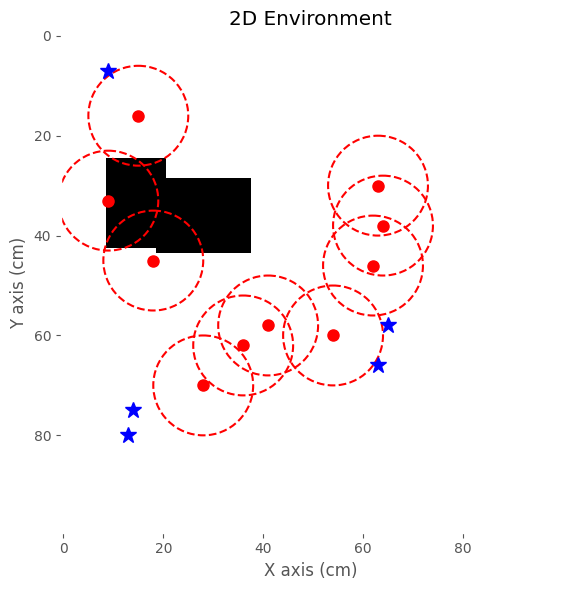

In [988]:
plot_2d_environment(final_env, radii=radii)

## loss and fitness graphing

<Axes: >

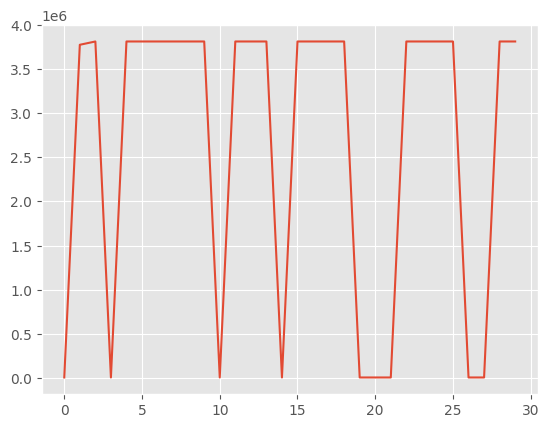

In [989]:
sns.lineplot(ft_dure_gen)